In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans
import keras.applications

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
file_path='/Users/apple/Downloads/UnSupCourse/Project/MURA-v1.1/train/'
categories=['ELBOW','FINGER','HUMERUS','SHOULDER']

In [5]:
print('start time: '+str(time.time()))
count=0
image_data=[]
labels = []
for cat in categories:
    num_images = 0
    patient=os.path.join(file_path,cat)
    classify=categories.index(cat)
#     print(patient)
    for patient_id in os.listdir(patient):
        study=os.path.join(patient,patient_id)
        for studies in os.listdir(study):
            if 'negative' in studies:
                images=os.path.join(study,studies)
                for image in os.listdir(images):

                    try:
                        if True:
                            count+=1
                            if (count%500==0):
                                print(str(count)+': images read')

                            img_array= cv2.imread(os.path.join(images,image))
                            new_array=cv2.resize(img_array,(224,224))
                            new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
                            image_data.append(new_array)
                            labels.append(classify)
                            num_images += 1
                    except:
                        print("failed at: "+str(images))
                        print("failed for: "+str(image))
                        continue
                
                
                
            

#             break
#         break
#     break
        
        
print('end time'+str(time.time()))        

start time: 1543792687.552854
500: images read
1000: images read
1500: images read
2000: images read
2500: images read
3000: images read
3500: images read
4000: images read
4500: images read
5000: images read
5500: images read
6000: images read
6500: images read
7000: images read
7500: images read
8000: images read
8500: images read
9000: images read
9500: images read
10000: images read
10500: images read
end time1543792748.9621801


In [6]:
import pickle
pickle_write=open('/Users/apple/Downloads/UnSupCourse/Project/image_data_4classes.pickle','wb')
pickle.dump(image_data,pickle_write)
pickle_write=open('/Users/apple/Downloads/UnSupCourse/Project/labels_4classes.pickle','wb')
pickle.dump(labels,pickle_write)
pickle_write.close()

In [ ]:
impo

In [6]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [7]:
image_data, labels = normalise_images(image_data, labels)

In [8]:

# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [10]:
vgg16_output = covnet_transform(vgg16_model, image_data)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, image_data)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, image_data)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


In [11]:
import pickle
pickle_write=open('/Users/apple/Downloads/UnSupCourse/Project/vgg_16.pickle','wb')
pickle.dump(vgg16_output,pickle_write)
pickle_write=open('/Users/apple/Downloads/UnSupCourse/Project/vgg_19.pickle','wb')
pickle.dump(vgg19_output,pickle_write)
pickle_write=open('/Users/apple/Downloads/UnSupCourse/Project/resnet_50.pickle','wb')
pickle.dump(resnet50_output,pickle_write)
pickle_write.close()

In [12]:

# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [15]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)

In [16]:
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

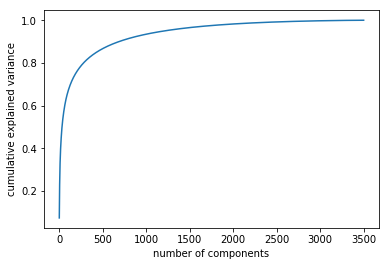

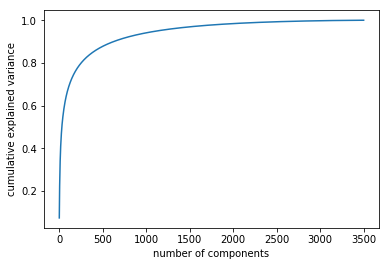

In [17]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)

In [18]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)

In [23]:
def create_train_kmeans(data, number_of_clusters=len(np.unique(labels))):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [173]:
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca, number_of_clusters = 90)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca, number_of_clusters = 90)

KMeans (PCA): 

VGG16
Training took 40.98236632347107 seconds

VGG19
Training took 40.89957571029663 seconds


In [174]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output, number_of_clusters = 90)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output, number_of_clusters = 90)

KMeans: 

VGG16:
Training took 311.5831639766693 seconds

VGG19:
Training took 308.45089292526245 seconds


In [175]:
# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)

In [94]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    cluster_df.index = categories
    return cluster_df

In [176]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, labels)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, labels)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, labels)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, labels)

In [154]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
ELBOW,4,5,26,8,5,34,0,8,17,2,...,0,8,62,12,0,60,0,0,0,19
FINGER,3,2,5,7,1,8,0,1,46,1,...,0,37,15,5,30,0,0,1,55,3
FOREARM,4,13,7,11,15,5,1,24,8,0,...,13,25,16,3,6,2,0,2,0,34
HAND,6,0,40,5,0,2,1,3,21,0,...,0,58,29,6,0,0,1,3,1,4
HUMERUS,0,2,0,19,60,5,2,36,3,6,...,5,21,0,0,0,2,5,34,0,18
SHOULDER,0,41,4,0,1,5,47,1,22,100,...,6,68,0,1,0,0,97,15,0,0
WRIST,33,0,29,4,0,9,4,3,5,1,...,2,7,43,73,5,0,0,1,0,17


In [155]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
ELBOW,4,5,26,8,5,34,0,8,17,2,...,0,8,62,12,0,60,0,0,0,19
FINGER,3,2,5,7,1,8,0,1,46,1,...,0,37,15,5,30,0,0,1,55,3
FOREARM,4,13,7,11,15,5,1,24,8,0,...,13,25,16,3,6,2,0,2,0,34
HAND,6,0,40,5,0,2,1,3,21,0,...,0,58,29,6,0,0,1,3,1,4
HUMERUS,0,2,0,19,60,5,2,36,3,6,...,5,21,0,0,0,2,5,34,0,18
SHOULDER,0,41,4,0,1,5,47,1,22,100,...,6,68,0,1,0,0,97,15,0,0
WRIST,33,0,29,4,0,9,4,3,5,1,...,2,7,43,73,5,0,0,1,0,17


In [156]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
ELBOW,6,0,20,28,42,4,0,30,0,29,...,14,5,0,9,7,0,0,37,18,29
FINGER,4,1,4,0,18,32,0,9,2,4,...,1,0,0,1,7,0,0,12,0,5
FOREARM,4,0,54,27,15,9,13,15,2,36,...,10,16,0,42,12,0,2,16,2,9
HAND,2,0,0,0,23,25,0,35,0,1,...,1,4,1,0,4,27,1,20,23,42
HUMERUS,66,0,29,7,0,9,5,0,66,7,...,0,68,5,70,16,0,2,0,4,1
SHOULDER,1,1,6,8,3,41,6,12,0,3,...,0,1,93,1,0,0,38,10,4,6
WRIST,0,0,18,2,41,4,2,12,0,1,...,44,2,1,5,4,1,1,5,5,4


In [157]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
ELBOW,2,27,39,0,20,30,29,9,0,5,...,15,24,4,0,8,11,0,0,10,7
FINGER,3,4,4,25,1,10,9,66,0,6,...,2,60,0,62,8,15,1,0,0,8
FOREARM,2,8,3,15,47,12,13,9,0,8,...,6,2,7,3,5,18,2,0,0,3
HAND,1,45,31,2,0,15,16,10,56,1,...,3,26,0,1,26,21,1,2,20,68
HUMERUS,0,0,0,2,22,1,0,1,0,1,...,0,4,37,0,33,4,3,6,0,2
SHOULDER,19,4,2,0,5,3,2,4,0,22,...,0,13,0,0,34,6,39,97,3,6
WRIST,0,29,28,17,12,9,7,13,0,0,...,46,2,0,3,10,23,3,2,0,12


In [52]:
# 7 clusters
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["HUMERUS", "SHOULDER", "ELBOW", "FINGER", "HAND", "FOREARM", "HUMERUS"]
vgg16_cluster_code_pca = ["HUMERUS", "SHOULDER", "ELBOW", "FINGER", "HAND", "FOREARM", "HUMERUS"]

vgg19_cluster_code = ["HUMERUS", "WRIST", "ELBOW", "SHOULDER", "HUMERUS", "FOREARM", "FINGER"]
vgg19_cluster_code_pca = ["HUMERUS", "WRIST", "ELBOW", "SHOULDER", "HUMERUS", "FOREARM", "FINGER"]

In [113]:
# 10 clusters
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["HUMERUS", "ELBOW", "FINGER", "SHOULDER", "WRIST", "HUMERUS", "FOREARM", "SHOULDER", "HAND", "ELBOW"]
vgg16_cluster_code_pca = ["HUMERUS", "ELBOW", "FINGER", "SHOULDER", "WRIST", "HUMERUS", "FOREARM", "SHOULDER", "HAND", "ELBOW"]

vgg19_cluster_code = ["FOREARM", "ELBOW", "FOREARM", "SHOULDER", "WRIST", "FINGER", "HAND", "HUMERUS", "HUMERUS", "SHOULDER"]
vgg19_cluster_code_pca = ["FOREARM", "ELBOW", "FOREARM", "SHOULDER", "WRIST", "FINGER", "HAND", "HUMERUS", "HUMERUS", "SHOULDER"]

In [177]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = list(vgg16_cluster_count.idxmax(axis=0))
vgg16_cluster_code_pca = list(vgg16_cluster_count_pca.idxmax(axis=0))

vgg19_cluster_code = list(vgg19_cluster_count.idxmax(axis=0))
vgg19_cluster_code_pca = list(vgg19_cluster_count_pca.idxmax(axis=0))

In [178]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]

In [179]:
from collections import Counter
Counter(vgg16_pred_codes)

Counter({'ELBOW': 604,
         'FINGER': 523,
         'FOREARM': 422,
         'HAND': 430,
         'HUMERUS': 505,
         'SHOULDER': 456,
         'WRIST': 560})

In [136]:
label_names = []
for labs in labels:
    if labs == 0:
        label_names.append('ELBOW')
    elif labs == 1:
        label_names.append('FINGER')
    elif labs == 2:
        label_names.append('FOREARM')        
    elif labs == 3:
        label_names.append('HAND')
    elif labs == 4:
        label_names.append('HUMERUS')
    elif labs == 5:
        label_names.append('SHOULDER')
    elif labs == 6:
        label_names.append('WRIST')

In [180]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(label_names, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(label_names, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(label_names, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(label_names, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.60981966   |   Accuracy: 0.60981966
KMeans VGG16 (PCA) 
	F1 Score: 0.60981966   |   Accuracy: 0.60981966

KMeans VGG19:  
	F1 Score: 0.57615424   |   Accuracy: 0.57615424
KMeans VGG19 (PCA):  
	F1 Score: 0.57554806   |   Accuracy: 0.57554806


In [184]:
for i in range(7):
    print(Counter(vgg16_pred_codes[i*500:(i+1)*500]))

Counter({'ELBOW': 282, 'WRIST': 70, 'FOREARM': 64, 'HAND': 35, 'FINGER': 26, 'HUMERUS': 19, 'SHOULDER': 4})
Counter({'FINGER': 302, 'ELBOW': 54, 'WRIST': 50, 'HAND': 48, 'HUMERUS': 18, 'FOREARM': 17, 'SHOULDER': 11})
Counter({'FOREARM': 233, 'ELBOW': 76, 'HUMERUS': 73, 'WRIST': 43, 'FINGER': 42, 'SHOULDER': 20, 'HAND': 13})
Counter({'HAND': 267, 'FINGER': 74, 'WRIST': 66, 'ELBOW': 63, 'SHOULDER': 14, 'HUMERUS': 13, 'FOREARM': 3})
Counter({'HUMERUS': 359, 'FOREARM': 66, 'ELBOW': 31, 'SHOULDER': 23, 'WRIST': 12, 'FINGER': 5, 'HAND': 4})
Counter({'SHOULDER': 376, 'HAND': 30, 'ELBOW': 29, 'FOREARM': 22, 'FINGER': 21, 'HUMERUS': 14, 'WRIST': 8})
Counter({'WRIST': 311, 'ELBOW': 69, 'FINGER': 53, 'HAND': 33, 'FOREARM': 17, 'HUMERUS': 9, 'SHOULDER': 8})


In [185]:
categories

['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER', 'WRIST']